# 2d Bilby-Cottrell-Swinden-Dugdale Cohesive Crack example 
Plane-Elasticity example - using segment element with constant displacement discontinuity elements (kernel '2DS0-H').

We investigate the case of cohesive crack with a rectangular (Dugdale/Barenblatt type) traction separation law under uniform remote tension $\sigma_A$. 
The corresponding normal traction for the BCSD crack is given as
$$
T_n(x) =
    \begin{cases}
        \sigma_A & \text{if } x \leq |a|\\
        \sigma_A-\sigma_c & \text{if } |c| \geq x > |a|
    \end{cases}
$$
with $ \sigma_c$ the peak tensile strength, and $c-a$ the cohesive zone length.

The corresponding normal displacement discontinuity solution  is given as seen in Weertman (1996), 
$$
d_n(x) = {2 (1-\nu) \sigma_c \over \pi G} \{ x \ln \big| {x\sqrt{c^2 - a^2} + a\sqrt{c^2 - x^2} \over x\sqrt{c^2 - a^2} - a\sqrt{c^2 - x^2}} \big| - a \ln \big| {\sqrt{c^2 - a^2} + \sqrt{c^2 - x^2} \over \sqrt{c^2 - a^2} - \sqrt{c^2 - x^2}} \big| \}
$$



In [11]:
import numpy as np
import sys
import os
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
#plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

from bigwham4py import BEMatrix  

In [28]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
alpha = 1 - nu

sig_C = 1.0
sigma_A = (4*sig_C)/9

ct_pressure = -sigma_A
pz_pressure = sig_C - sigma_A

pre_fac = - 2 * ((alpha*sig_C) / (np.pi*G))

a = 1.0 
pz_fac = 1 / (np.cos((np.pi*sigma_A)/(2*sig_C)))
c = a*pz_fac

#plastic zone formula
#pz_fac_2 = 1 + 2*pz_fac*np.sin((np.pi*sigma_A)/(4*sig_C))**2
#c_2 = a*pz_fac_2

# Mesh
nelts = 60
coor1D = np.linspace(-c, c, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameters
max_leaf_size = 100
eta = 3.
eps_aca = 1.e-5

# Hmatrix
kernel = "2DS0-H"
elas_prop = np.array([E, nu])
hmat = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)

col_pts = hmat.getMeshCollocationPoints()

NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.006235
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 3
Hierarchical matrix  construction time = :  0.006257
BigWham constructed Hmat of size (60 x 2) X (60 x 2)
--------------------


## Prescribing the displacement discontinuity solution / checking the resulting traction 
We first test the accuracy of the traction obtained (by simple BE matrix vector multiplication) when we prescribe the exact displacement discontinuity solution.

In [29]:
dd = np.zeros(col_pts.shape)

pzl2 = np.sqrt(c**2 - a**2)
x_pzl2 = col_pts[:, 0]*pzl2
ctzl2 = np.sqrt(c**2 - col_pts[:, 0]**2)
a_ctzl2 = a*ctzl2

dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 1] = ct_pressure
for i in range(len(t_anal)):
    if abs(col_pts[i][0])>=a:
        t_anal[i][1] = pz_pressure

(0.0, 2.0)

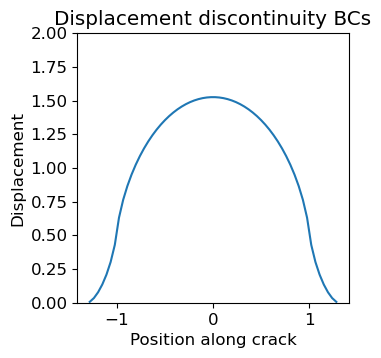

In [30]:
dd_norm = dd/(-a*pre_fac)
plt.plot(col_pts[:, 0], dd_norm[:, 1])
plt.title("Displacement discontinuity BCs")
plt.xlabel("Position along crack")
plt.ylabel("Displacement")
# plt.show()
plt.ylim([0, 2])

Calculated pressure between x = - 1.0  and + 1.0 is =  0.4436460231587676
Calculated pressure between |x| =  1.0  and  1.3054072893322786  is =  -0.5526581664869264


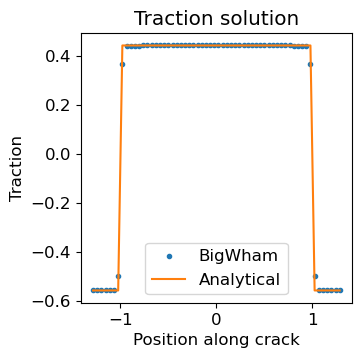

In [31]:
t_anal = np.zeros(col_pts.shape)
t_anal[:, 1] = -ct_pressure
for i in range(len(t_anal)):
    if abs(col_pts[i][0])>=a:
        t_anal[i][1] = -pz_pressure

plt.plot(col_pts[:, 0], t.reshape(-1, 2)[:, 1], ".")
plt.plot(col_pts[:, 0], t_anal[:, 1])

plt.legend(["BigWham", "Analytical"])
# plt.xlim([-1 - 10 * 2 * c / nelts, -1 + 10 * 2 * c / nelts])
plt.title("Traction solution")
plt.xlabel("Position along crack")
plt.ylabel("Traction")

print("Calculated pressure between x = -", a , " and +", a , "is = ", t[101])
print("Calculated pressure between |x| = ", a , " and ", c , " is = ", t[1])

# Prescribing tractions and solving for the displacement discontinuities


Pressure between x = - 1.0  and + 1.0 is =  -0.4444444444444444
Pressure between |x| =  1.0  and  1.3054072893322786  is =  0.5555555555555556


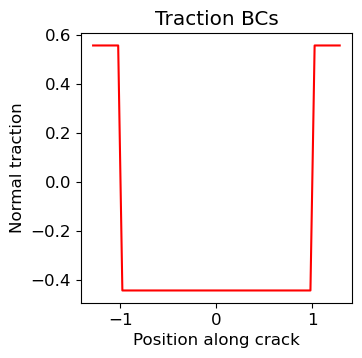

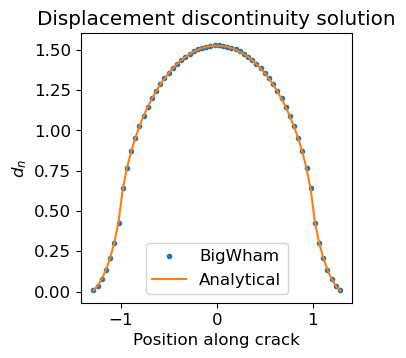

In [32]:
trac = np.zeros(col_pts.shape)
trac[:, 1] = ct_pressure
for i in range(len(trac)):
    if abs(col_pts[i][0])>=a:
        trac[i][1] = pz_pressure
#print(trac)
plt.figure()
plt.plot(col_pts[:, 0], trac[:, 1], color='r')
plt.title("Traction BCs")
plt.xlabel("Position along crack")
plt.ylabel("Normal traction")
print("Pressure between x = -", a , " and +", a , "is = ", ct_pressure)
print("Pressure between |x| = ", a , " and ", c , " is = ", pz_pressure)

from scipy.sparse.linalg import gmres


u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
dd_calc = hmat.convert_to_global(u)

info
dd_calc_norm = dd_calc/(a*pre_fac)

pzl2 = np.sqrt(c**2 - a**2)
x_pzl2 = col_pts[:, 0]*pzl2
ctzl2 = np.sqrt(c**2 - col_pts[:, 0]**2)
a_ctzl2 = a*ctzl2
dd =  np.zeros(col_pts.shape)
dd[:, 1] = -(col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

plt.figure()
plt.title("Displacement discontinuity solution")
plt.xlabel("Position along crack")
plt.ylabel("$d_n$")
#plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
plt.plot(col_pts[:, 0], dd_calc_norm.reshape(-1, 2)[:, 1], ".")
plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1])
plt.legend(["BigWham", "Analytical"])
#plt.ylim([-0.01, 0.01])

# Convergence study with number of elements

## Prescribing the displacement discontinuity solution

In [6]:
nelts_array = [10**i for i in range(6)]
rel_err_array = []

for nelts in nelts_array:
    # Mesh
    coor1D = np.linspace(-c, c, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

    # H-matrix parameters
    max_leaf_size = 100
    eta = 3.
    eps_aca = 1.e-4

    # Hmatrix
    kernel = "2DS0-H"
    elas_prop = np.array([E, nu])
    hmat = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)

    col_pts = hmat.getMeshCollocationPoints()

    dd = np.zeros(col_pts.shape)

    pzl2 = np.sqrt(c**2 - a**2)
    x_pzl2 = col_pts[:, 0]*pzl2
    ctzl2 = np.sqrt(c**2 - col_pts[:, 0]**2)
    a_ctzl2 = a*ctzl2

    dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

    # calculate tractions
    t = hmat.matvec(dd.flatten())

    t_anal = np.zeros(col_pts.shape)
    t_anal[:, 1] = ct_pressure
    for i in range(len(t_anal)):
        if abs(col_pts[i][0])>=a:
            t_anal[i][1] = pz_pressure

    rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_err_array.append(rel_err)

    '''
    info
    dd_calc_norm = dd_calc/(a*pre_fac)
    plt.figure()
    #plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
    plt.plot(col_pts[:, 0], dd_calc_norm.reshape(-1, 2)[:, 1], ".")
    plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1], ".")
    #plt.ylim([-0.01, 0.01])
    '''

NUM OF AVAILABLE OMP THREADS: 16
L2 Rel error 0.340651021557473
L2 Rel error 0.14298168129296
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =0
 Number of low rank blocks =1
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 0 
Loop on low rank blocks construction
N low rank blocks 1
dof_dimension: 2
Creation of hmat done in 0.001739
Compression ratio - 2
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 2, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  0.001757
BigWham constructed Hmat of

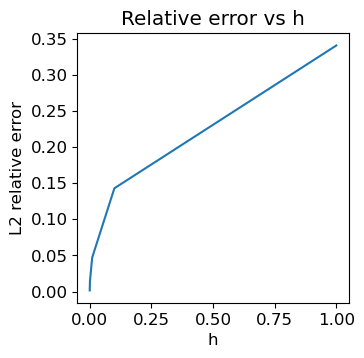

In [7]:
h_array = [1/nelts for nelts in nelts_array]

plt.figure()
plt.plot(h_array, rel_err_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

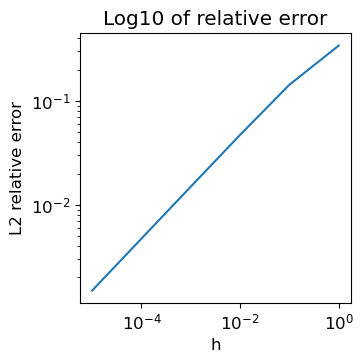

In [8]:
plt.figure()
plt.plot(h_array, rel_err_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [9]:
print(h_array)

print(rel_err_array)

log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_err_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[0.340651021557473, 0.14298168129296, 0.04709568447731429, 0.014946281372668653, 0.004727695970546321, 0.001495073947955563]
0.4994838931808649
-0.7543263091404309


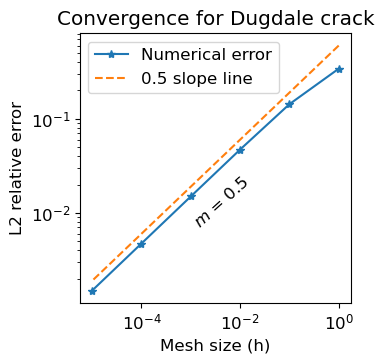

In [10]:
plt.figure()
plt.plot(h_array, rel_err_array, "*-")
plt.plot(h_array, 0.6*np.array(h_array) ** (0.5) , "--")
plt.title("Convergence for Dugdale crack")

plt.text(0.001, 0.007, r'$m$' + ' = 0.5', rotation=42)
plt.legend(["Numerical error", "0.5 slope line"])

plt.xlabel("Mesh size (h)")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
#saves fig - remember to remove
# plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
# plt.show()